# Optimising irrigation scheduling
* **Compatibility:** Sugarcane simulation database for a range of irrigation schedules were generated with APSIM 7.10 r4158  
* **Products used:** UniSQ CACS' calibrated sugarcane yield simulation database ([An-Vo et al. 2019, European Journal of Agronomy](https://www.sciencedirect.com/science/article/pii/S1161030118301990))

## Background
Sugarcane growing is an important farming business in Queensland contributing to the majority of sugar production in Australia. Cane crop is a perennial crop with a cropping cycle being 5 to 6 years. Each crop cycle includes one plant crop and 2-4 ratoon crops. Irrigation is required to guarantee economic viability of sugarcane farming in Queensland given the climate variability and change. Here we demonstrate how to use crop modelling and economic analysis to optimise irrigation schedules in plant and ratoon crops, achieving the best profit (Figure 1).   

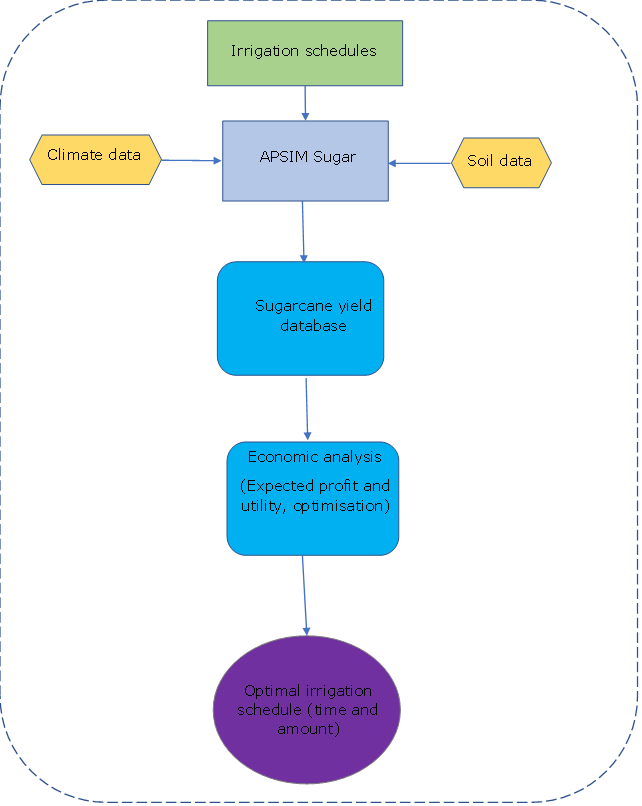

Figure 1. Conceptualisation of the sugarcane irrigation scheduling optimisation

## Description
This notebook presents the workflow to analyse the sugarcane yield simulation database generated by APSIM-Sugar. Expected yield and gross margin in each irrigation schedule is estimated and the optimal schedule is recommended for a plant crop or a ratoon crop. 

## Getting started

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import urllib.request                               # To work with SILO url
import urllib.parse                                 # To work with SILO url
import io                                           # To instantiate the file-like object of data in byte type with API access

## Sugarcane irrigation data

In [2]:
# Loading simulation data for each irrigation schedule (amount)
I5mm = r'Sugar5mm_n1.csv'
dfI5 = pd.read_csv(I5mm)
dfI5

,Date,day,sucrose_wt,lai,irrigation,fertiliser,ratoon_no,ccs,canefw
0,01/01/1889,1,0.0,0.0,0,0,0,0.0,0.0
1,02/01/1889,2,0.0,0.0,0,0,0,0.0,0.0
2,03/01/1889,3,0.0,0.0,0,0,0,0.0,0.0
3,04/01/1889,4,0.0,0.0,0,0,0,0.0,0.0
4,05/01/1889,5,0.0,0.0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
46016,28/12/2014,362,0.0,0.0,0,0,0,0.0,0.0
46017,29/12/2014,363,0.0,0.0,0,0,0,0.0,0.0
46018,30/12/2014,364,0.0,0.0,5,0,0,0.0,0.0
46019,31/12/2014,365,0.0,0.0,0,0,0,0.0,0.0


In [3]:
# Climate data at the site
api_url = 'https://www.longpaddock.qld.gov.au/cgi-bin/silo'
params = {
    'format': 'csv',
    'station': '033002',
    'start': '18890101',
    'finish': '20141231',
    'username': 'duc-anh.an-vo@usq.edu.au',
    'comment': 'R'
}    
url = api_url + '/PatchedPointDataset.php?' + urllib.parse.urlencode(params)
with urllib.request.urlopen(url) as remote:
    data = remote.read()
datafile = io.StringIO(data.decode())       # Instantiate the file-like object
dfC = pd.read_csv(datafile)
dfC

,station,YYYY-MM-DD,daily_rain,daily_rain_source,metadata
0,33002,1889-01-01,4.9,25,name=AYR DPI RESEARCH STN
1,33002,1889-01-02,0.8,25,latitude= -19.6169
2,33002,1889-01-03,3.7,25,longitude= 147.3758
3,33002,1889-01-04,0.5,25,elevation= 17.0 m
4,33002,1889-01-05,2.2,25,reference=R
...,...,...,...,...,...
46015,33002,2014-12-27,0.0,0,NaN
46016,33002,2014-12-28,0.0,0,NaN
46017,33002,2014-12-29,0.0,0,NaN
46018,33002,2014-12-30,0.0,0,NaN


In [4]:
# Create a new dataframe combining the climate data and sugarcane simulation data and set the years as the dataframe index 
Year = [datetime.strptime(dfI5['Date'][i],'%d/%m/%Y').year for i, _ in dfI5.iterrows()]      # Create a list for years
dfI = pd.DataFrame({})
dfI['Year'] = Year
dfI['Rain'] = dfC.daily_rain
dfI['Irrigation'] = dfI5.irrigation
dfI['Fertiliser'] = dfI5.fertiliser
dfI['CCS'] = dfI5.ccs
dfI['Canefw'] = dfI5.canefw
dfI = dfI.set_index('Year')
dfI

,Rain,Irrigation,Fertiliser,CCS,Canefw
Year,,,,,
1889,4.9,0,0,0.0,0.0
1889,0.8,0,0,0.0,0.0
1889,3.7,0,0,0.0,0.0
1889,0.5,0,0,0.0,0.0
1889,2.2,0,0,0.0,0.0
...,...,...,...,...,...
2014,0.0,0,0,0.0,0.0
2014,0.0,0,0,0.0,0.0
2014,0.0,5,0,0.0,0.0


In [5]:
# Define a function converting a number to a string in a specific format
def num2str(a):
    b = a - int(a)
    if b > 0:
        return str(int(a))+'_'+str(int(b*10))
    else:
        return str(a)

In [7]:
# Initiate the dataframes
dfRaPs = pd.DataFrame({})                                          # Dataframe for total rainfall of plant crops in all irrigation schedules
dfRaR1s = pd.DataFrame({})                                         # Dataframe for total rainfall of ratoon 1 crops in all irrigation schedules
dfRaR2s = pd.DataFrame({})                                         # Dataframe for total rainfall of ratoon 2 crops in all irrigation schedules
dfRaR3s = pd.DataFrame({})                                         # Dataframe for total rainfall of ratoon 3 crops in all irrigation schedules
dfRaR4s = pd.DataFrame({})                                         # Dataframe for total rainfall of ratoon 4 crops in all irrigation schedules
#
dfNPs = pd.DataFrame({})                                           # Dataframe for total fertiliser of plant crops in all irrigation schedules
dfNR1s = pd.DataFrame({})                                          # Dataframe for total fertiliser of ratoon 1 crops in all irrigation schedules
dfNR2s = pd.DataFrame({})                                          # Dataframe for total fertiliser of ratoon 2 crops in all irrigation schedules
dfNR3s = pd.DataFrame({})                                          # Dataframe for total fertiliser of ratoon 3 crops in all irrigation schedules
dfNR4s = pd.DataFrame({})                                          # Dataframe for total fertiliser of ratoon 4 crops in all irrigation schedules
#
dfIrPs = pd.DataFrame({})                                          # Dataframe for total irrigation of plant crops in all irrigation schedules
dfIrR1s = pd.DataFrame({})                                         # Dataframe for total irrigation of ratoon 1 crops in all irrigation schedules
dfIrR2s = pd.DataFrame({})                                         # Dataframe for total irrigation of ratoon 2 crops in all irrigation schedules
dfIrR3s = pd.DataFrame({})                                         # Dataframe for total irrigation of ratoon 3 crops in all irrigation schedules
dfIrR4s = pd.DataFrame({})                                         # Dataframe for total irrigation of ratoon 4 crops in all irrigation schedules
#
dfFCPs = pd.DataFrame({})                                          # Dataframe for total fresh cane yield of plant crops in all irrigation schedules
dfFCR1s = pd.DataFrame({})                                         # Dataframe for total fresh cane yield of ratoon 1 crops in all irrigation schedules
dfFCR2s = pd.DataFrame({})                                         # Dataframe for total fresh cane yield of ratoon 2 crops in all irrigation schedules
dfFCR3s = pd.DataFrame({})                                         # Dataframe for total fresh cane yield of ratoon 3 crops in all irrigation schedules
dfFCR4s = pd.DataFrame({})                                         # Dataframe for total fresh cane yield of ratoon 4 crops in all irrigation schedules
#
dfCPs = pd.DataFrame({})                                           # Dataframe for CCS at harvest of plant crops in all irrigation schedules
dfCR1s = pd.DataFrame({})                                          # Dataframe for CCS at harvest of ratoon 1 crops in all irrigation schedules
dfCR2s = pd.DataFrame({})                                          # Dataframe for CCS at harvest of ratoon 2 crops in all irrigation schedules
dfCR3s = pd.DataFrame({})                                          # Dataframe for CCS at harvest of ratoon 3 crops in all irrigation schedules
dfCR4s = pd.DataFrame({})                                          # Dataframe for CCS at harvest of ratoon 4 crops in all irrigation schedules
# Looping among all irrigation schedules (amounts)
for a in [5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 55, 60, 65, 70, 75, 80]: 
    Ia = r'Sugar'+num2str(a)+'mm_n1.csv'                                                         # Forming the filename
    dfIa = pd.read_csv(Ia)
    # Create a new dataframe combining the climate data and sugarcane simulation data and set the years as the dataframe index 
    Year = [datetime.strptime(dfIa['Date'][i],'%d/%m/%Y').year for i, _ in dfIa.iterrows()]      # Create a list for years
    dfI = pd.DataFrame({})
    dfI['Year'] = Year
    dfI['Rain'] = dfC.daily_rain
    dfI['Irrigation'] = dfIa.irrigation
    dfI['Fertiliser'] = dfIa.fertiliser
    dfI['CCS'] = dfIa.ccs
    dfI['Canefw'] = dfIa.canefw
    dfI = dfI.set_index('Year')
    #
    RaPs = []; RaR1s = []; RaR2s = []; RaR3s = []; RaR4s = []                           # Total rainfall lists in plant crop and the 4 ratoons                          
    NPs = []; NR1s = []; NR2s = []; NR3s = []; NR4s = []                                # Total fertiliser lists in plant crop and the 4 ratoons
    IrPs = []; IrR1s = []; IrR2s = []; IrR3s = []; IrR4s = [];                          # Total irrigation water lists in plant crop and the 4 ratoons
    fCPs = []; fCR1s = []; fCR2s = []; fCR3s = []; fCR4s = [];                          # Fresh cane yields (t/ha)
    CPs = []; CR1s = []; CR2s = []; CR3s = []; CR4s = [];                               # CCS (%) 
    for i in np.arange(1, 22, 1):                                                           # From 1889 to 2014 there are 21 cycles of 6 years
        # Plant crop
        Plant_Year = 1889 + (i-1)*6
        ndays = len(dfI.loc[Plant_Year, :])                                                 # Number of days in a plant crop year
        if ndays > 365:                                                                     # A bissextile year
            P_Start = 120
        else:
            P_Start = 119
        RaP = dfI.loc[Plant_Year:Plant_Year + 1, 'Rain'].iloc[P_Start:P_Start + 450].sum()             # Total rainfall for 450 days of the plant crop
        NP = dfI.loc[Plant_Year:Plant_Year + 1, 'Fertiliser'].iloc[P_Start:P_Start + 450].sum()        # Total fertiliser for 450 days of the plant crop
        IrP = dfI.loc[Plant_Year:Plant_Year + 1, 'Irrigation'].iloc[P_Start:P_Start + 450].sum()       # Total irrigation water for 450 days of the plant crop
        fCP = dfI.loc[Plant_Year:Plant_Year + 1, 'Canefw'].iloc[P_Start + 449]                         # Fresh cane yield at harvest
        CP = dfI.loc[Plant_Year:Plant_Year + 1, 'CCS'].iloc[P_Start + 449]                             # CCS at harvest
        #
        RaPs.append(RaP)
        NPs.append(NP)
        IrPs.append(IrP)
        fCPs.append(fCP)
        CPs.append(CP)
        #
        # Ratoon 1
        R1_Start = P_Start + 450 - ndays
        RaR1 = dfI.loc[Plant_Year + 1:Plant_Year + 2, 'Rain'].iloc[R1_Start:R1_Start+390].sum()        # Total rainfall for 390 days of the ratoon 1 crop
        NR1 = dfI.loc[Plant_Year + 1:Plant_Year + 2, 'Fertiliser'].iloc[R1_Start:R1_Start+390].sum()   # Total fertiliser for 390 days of the ratoon 1 crop
        IrR1 = dfI.loc[Plant_Year + 1:Plant_Year + 2, 'Irrigation'].iloc[R1_Start:R1_Start+390].sum()  # Total irrigation water for 390 days of the ratoon 1 crop
        fCR1 = dfI.loc[Plant_Year + 1:Plant_Year + 2, 'Canefw'].iloc[R1_Start+389]                     # Fresh cane yield at harvest
        CR1 = dfI.loc[Plant_Year + 1:Plant_Year + 2, 'CCS'].iloc[R1_Start+389]                         # CCS at harvest
        #
        RaR1s.append(RaR1)
        NR1s.append(NR1)
        IrR1s.append(IrR1)
        fCR1s.append(fCR1)
        CR1s.append(CR1)
        #
        # Ratoon 2
        R2_Start  = R1_Start + 390 - len(dfI.loc[Plant_Year + 1, :]) 
        RaR2 = dfI.loc[Plant_Year + 2:Plant_Year + 3, 'Rain'].iloc[R2_Start:R2_Start+390].sum()        # Total rainfall for 390 days of the ratoon 2 crop
        NR2 = dfI.loc[Plant_Year + 2:Plant_Year + 3, 'Fertiliser'].iloc[R2_Start:R2_Start+390].sum()   # Total fertiliser for 390 days of the ratoon 2 crop
        IrR2 = dfI.loc[Plant_Year + 2:Plant_Year + 3, 'Irrigation'].iloc[R2_Start:R2_Start+390].sum()  # Total irrigation water for 390 days of the ratoon 2 crop
        fCR2 = dfI.loc[Plant_Year + 2:Plant_Year + 3, 'Canefw'].iloc[R2_Start+389]                     # Fresh cane yield at harvest
        CR2 = dfI.loc[Plant_Year + 2:Plant_Year + 3, 'CCS'].iloc[R2_Start+389]                         # CCS at harvest
        #
        RaR2s.append(RaR2)
        NR2s.append(NR2)
        IrR2s.append(IrR2)
        fCR2s.append(fCR2)
        CR2s.append(CR2)
        #
        # Ratoon 3
        R3_Start  = R2_Start + 390 - len(dfI.loc[Plant_Year + 2, :]) 
        RaR3 = dfI.loc[Plant_Year + 3:Plant_Year + 4, 'Rain'].iloc[R3_Start:R3_Start+390].sum()        # Total rainfall for 390 days of the ratoon 3 crop
        NR3 = dfI.loc[Plant_Year + 3:Plant_Year + 4, 'Fertiliser'].iloc[R3_Start:R3_Start+390].sum()   # Total fertiliser for 390 days of the ratoon 3 crop
        IrR3 = dfI.loc[Plant_Year + 3:Plant_Year + 4, 'Irrigation'].iloc[R3_Start:R3_Start+390].sum()  # Total irrigation water for 390 days of the ratoon 3 crop
        fCR3 = dfI.loc[Plant_Year + 3:Plant_Year + 4, 'Canefw'].iloc[R3_Start+389]                     # Fresh cane yield at harvest
        CR3 = dfI.loc[Plant_Year + 3:Plant_Year + 4, 'CCS'].iloc[R3_Start+389]                         # CCS at harvest
        #
        RaR3s.append(RaR3)
        NR3s.append(NR3)
        IrR3s.append(IrR3)
        fCR3s.append(fCR3)
        CR3s.append(CR3)
        #
        # Ratoon 4
        R4_Start  = R3_Start + 390 - len(dfI.loc[Plant_Year + 3, :]) 
        RaR4 = dfI.loc[Plant_Year + 4:Plant_Year + 5, 'Rain'].iloc[R4_Start:R4_Start+390].sum()        # Total rainfall for 390 days of the ratoon 4 crop
        NR4 = dfI.loc[Plant_Year + 4:Plant_Year + 5, 'Fertiliser'].iloc[R4_Start:R4_Start+390].sum()   # Total fertiliser for 390 days of the ratoon 4 crop
        IrR4 = dfI.loc[Plant_Year + 4:Plant_Year + 5, 'Irrigation'].iloc[R4_Start:R4_Start+390].sum()  # Total irrigation water for 390 days of the ratoon 4 crop
        fCR4 = dfI.loc[Plant_Year + 4:Plant_Year + 5, 'Canefw'].iloc[R4_Start+389]                     # Fresh cane yield at harvest
        CR4 = dfI.loc[Plant_Year + 4:Plant_Year + 5, 'CCS'].iloc[R4_Start+389]                         # CCS at harvest
        #
        RaR4s.append(RaR4)
        NR4s.append(NR4)
        IrR4s.append(IrR4)
        fCR4s.append(fCR4)
        CR4s.append(CR4)
    # Rainfall
    dfRaPs[num2str(a)+'mm'] = RaPs
    dfRaR1s[num2str(a)+'mm'] = RaR1s
    dfRaR2s[num2str(a)+'mm'] = RaR2s
    dfRaR3s[num2str(a)+'mm'] = RaR3s
    dfRaR4s[num2str(a)+'mm'] = RaR4s
    # Fertiliser
    dfNPs[num2str(a)+'mm'] = NPs
    dfNR1s[num2str(a)+'mm'] = NR1s
    dfNR2s[num2str(a)+'mm'] = NR2s
    dfNR3s[num2str(a)+'mm'] = NR3s
    dfNR4s[num2str(a)+'mm'] = NR4s
    # Irrigation water
    dfIrPs[num2str(a)+'mm'] = IrPs
    dfIrR1s[num2str(a)+'mm'] = IrR1s
    dfIrR2s[num2str(a)+'mm'] = IrR2s
    dfIrR3s[num2str(a)+'mm'] = IrR3s
    dfIrR4s[num2str(a)+'mm'] = IrR4s
    # Fresh cane yield
    dfFCPs[num2str(a)+'mm'] = fCPs
    dfFCR1s[num2str(a)+'mm'] = fCR1s
    dfFCR2s[num2str(a)+'mm'] = fCR2s
    dfFCR3s[num2str(a)+'mm'] = fCR3s
    dfFCR4s[num2str(a)+'mm'] = fCR4s
    # CCS
    dfCPs[num2str(a)+'mm'] = CPs
    dfCR1s[num2str(a)+'mm'] = CR1s
    dfCR2s[num2str(a)+'mm'] = CR2s
    dfCR3s[num2str(a)+'mm'] = CR3s
    dfCR4s[num2str(a)+'mm'] = CR4s

## Fresh cane yield analysis

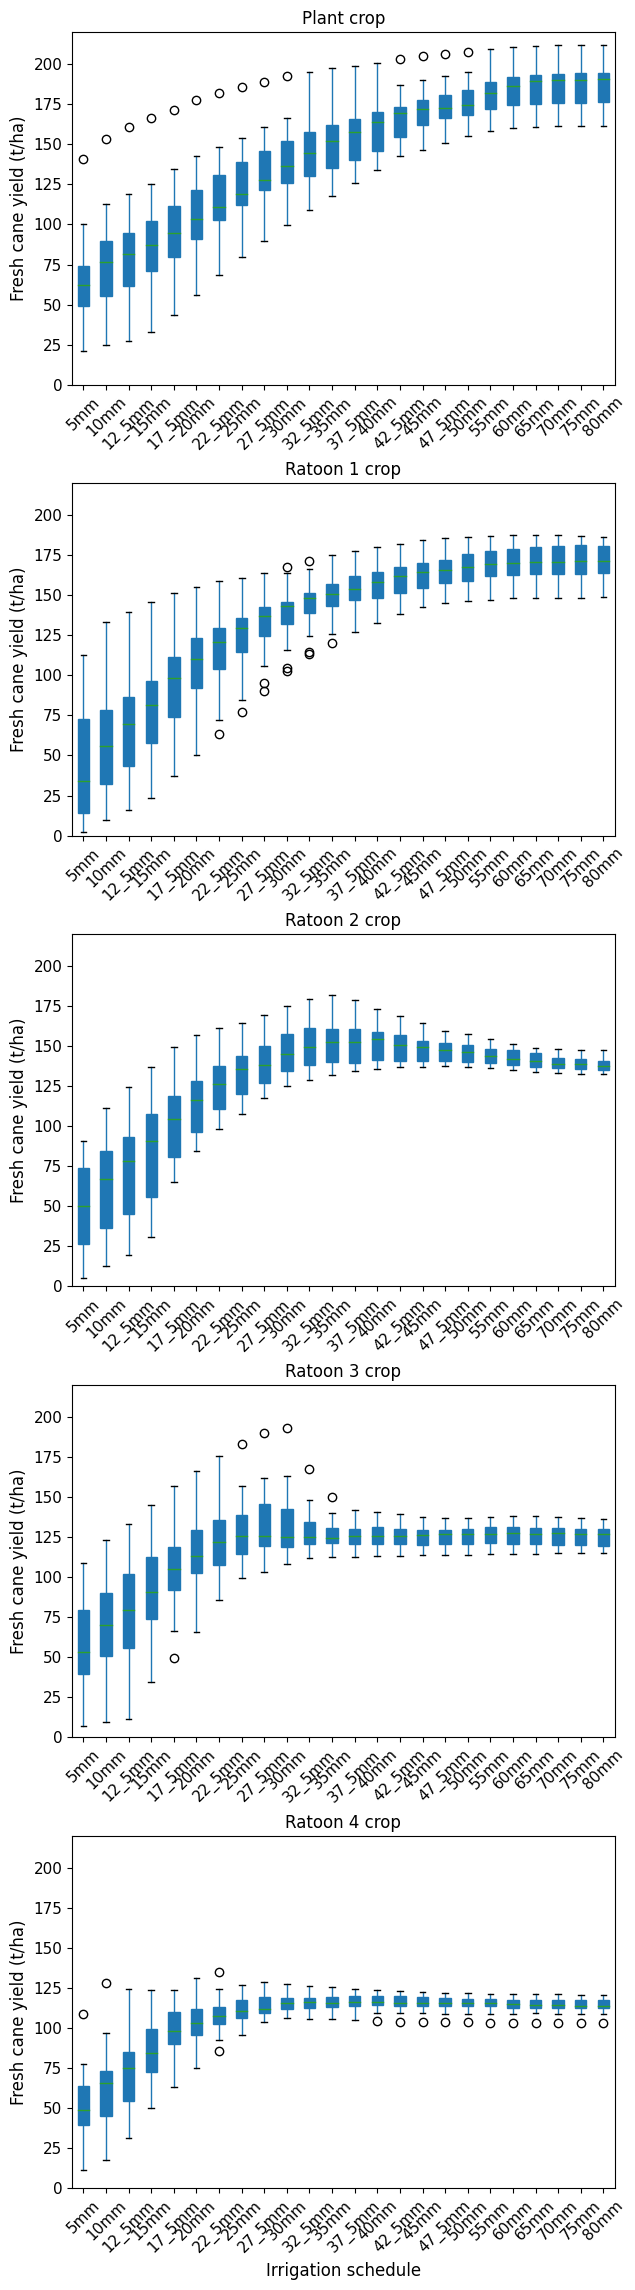

In [23]:
# Boxplots of fresh cane yields according to irrigation schedules
fig, ax = plt.subplots(5,1)
fig.set_size_inches(7, 28)
# Plant crop
dfFCPs.boxplot(ax = ax[0], rot=45, fontsize = 11, patch_artist = True, grid = False) 
#dfFCPs.boxplot(ax = ax, rot=45, fontsize = 13, grid = False) 
ax[0].set_title('Plant crop', fontsize=12)
ax[0].set_ylabel('Fresh cane yield (t/ha)', fontsize=12)
ax[0].set_ylim(0,220)
# Ratoon 1
dfFCR1s.boxplot(ax = ax[1], rot=45, fontsize = 11, patch_artist = True, grid = False) 
ax[1].set_title('Ratoon 1 crop', fontsize=12)
ax[1].set_ylabel('Fresh cane yield (t/ha)', fontsize=12)
ax[1].set_ylim(0,220)
# Ratoon 2
dfFCR2s.boxplot(ax = ax[2], rot=45, fontsize = 11, patch_artist = True, grid = False) 
ax[2].set_title('Ratoon 2 crop', fontsize=12)
ax[2].set_ylabel('Fresh cane yield (t/ha)', fontsize=12)
ax[2].set_ylim(0,220)
# Ratoon 3
dfFCR3s.boxplot(ax = ax[3], rot=45, fontsize = 11, patch_artist = True, grid = False) 
ax[3].set_title('Ratoon 3 crop', fontsize=12)
ax[3].set_ylabel('Fresh cane yield (t/ha)', fontsize=12)
ax[3].set_ylim(0,220)
# Ratoon 4
dfFCR4s.boxplot(ax = ax[4], rot=45, fontsize = 11, patch_artist = True, grid = False) 
ax[4].set_title('Ratoon 4 crop', fontsize=12)
ax[4].set_xlabel('Irrigation schedule', fontsize=12)
ax[4].set_ylabel('Fresh cane yield (t/ha)', fontsize=12)
ax[4].set_ylim(0,220)
fig.subplots_adjust(hspace=0.28)

## Gross margin analysis

In [11]:
# Gross margin calculation (will be presented next week)
# Plant crop
vcP = 2347                                                                # Variable cost (AUD ha^-1) without irrigation and fertiliser costs (see An-Vo et al.2019)
GMP = 39*dfFCPs - vcP - 30.67*dfIrPs/100 - 600*dfNPs/1000 - 7.2*dfFCPs    # Fresh cane price AUD 39/t, water price 30.67/ML, urea price AUD 600/t, harvesting cost AUD 7.2/t
# Ratoon 1
vcR1 = 1787                                                               # Variable cost (AUD ha^-1)
GMR1 = 39*dfFCR1s - vcR1 - 30.67*dfIrR1s/100 - 600*dfNR1s/1000 - 7.2*dfFCR1s
# Ratoon 2
vcR2 = 1787                                                               # Variable cost (AUD ha^-1)
GMR2 = 39*dfFCR2s - vcR2 - 30.67*dfIrR2s/100 - 600*dfNR2s/1000 - 7.2*dfFCR2s
# Ratoon 3
vcR3 = 1787                                                               # Variable cost (AUD ha^-1)
GMR3 = 39*dfFCR3s - vcR3 - 30.67*dfIrR3s/100 - 600*dfNR3s/1000 - 7.2*dfFCR3s
# Ratoon 4
vcR4 = 1787                                                               # Variable cost (AUD ha^-1)
GMR4 = 39*dfFCR4s - vcR4 - 30.67*dfIrR4s/100 - 600*dfNR4s/1000 - 7.2*dfFCR4s

In [12]:
GMR4

,5mm,10mm,12_5mm,15mm,17_5mm,20mm,22_5mm,25mm,27_5mm,30mm,...,42_5mm,45mm,47_5mm,50mm,55mm,60mm,65mm,70mm,75mm,80mm
0,1580.2737,2122.5048,1988.48835,1930.2195,1896.08685,1884.7230,1827.31275,1797.7275,1758.15705,1720.6536,...,1528.77975,1494.9015,1461.27765,1426.7316,1363.3953,1297.0062,1233.0021,1169.9838,1105.9161,1043.7246
1,-1513.4211,-1384.0176,-984.55725,-412.1049,-26.79555,311.4180,632.07795,926.3439,1140.95085,1313.5818,...,1384.59855,1361.3733,1336.87605,1309.9620,1253.9397,1194.3558,1133.3727,1070.3226,1007.8449,944.7948
2,151.9767,380.4690,702.40095,1052.7303,1517.57145,1915.2510,2207.32275,1788.2193,1723.08165,1623.2820,...,1346.56575,1312.7829,1296.45825,1273.0422,1222.5531,1150.1538,1052.6325,983.8266,915.7521,853.6242
3,-568.0318,-515.7680,-244.61710,302.7804,853.45330,1053.9446,1174.68150,1258.4986,1329.27770,1396.7178,...,1310.56490,1281.2058,1252.57810,1225.2860,1171.2742,1111.4748,1050.1808,987.9010,925.6848,866.8394
4,-259.8969,134.0826,458.08155,831.9747,1109.00505,953.4282,985.37595,1363.4667,1573.81245,1560.1272,...,1358.26815,1309.4121,1277.31465,1249.7328,1195.5867,1138.7694,1078.6131,1017.2802,954.4209,890.9256
5,65.8376,392.6308,733.13750,688.2282,1099.99870,1503.7238,1871.80110,1926.6802,1944.44870,1880.9046,...,1588.78310,1539.0084,1500.55450,1460.9876,1393.7152,1328.7642,1268.6150,1205.4448,1142.7516,1079.4224
6,-625.8513,-246.5316,14.37615,437.3049,986.67045,1037.7300,1187.81475,1333.2249,1404.15945,1403.4486,...,1317.08715,1307.7585,1284.46965,1259.6862,1203.1551,1137.8790,1073.2071,1007.1360,942.4005,878.9370
7,341.5754,856.8472,1104.46610,1394.7924,1742.74030,2106.3656,1695.91530,1668.6550,1667.69330,1602.2730,...,1404.72470,1384.3650,1313.15710,1267.6436,1189.0186,1113.5736,1042.2308,972.6370,907.3362,844.8974
8,-531.6279,-136.0902,146.37795,652.4955,1317.07245,1396.2114,1465.01535,1527.2685,1547.03685,1575.3912,...,1473.51135,1424.3055,1376.37165,1337.8824,1266.6915,1196.6772,1130.7333,1064.9802,1003.0749,939.6750
9,-735.1408,-594.6956,-284.90770,162.6696,884.64910,1438.6292,1515.29130,1287.4684,1352.58710,1388.1636,...,1311.70970,1282.5096,1251.24250,1212.4070,1142.0182,1057.4148,994.3400,932.0284,868.9218,806.5466


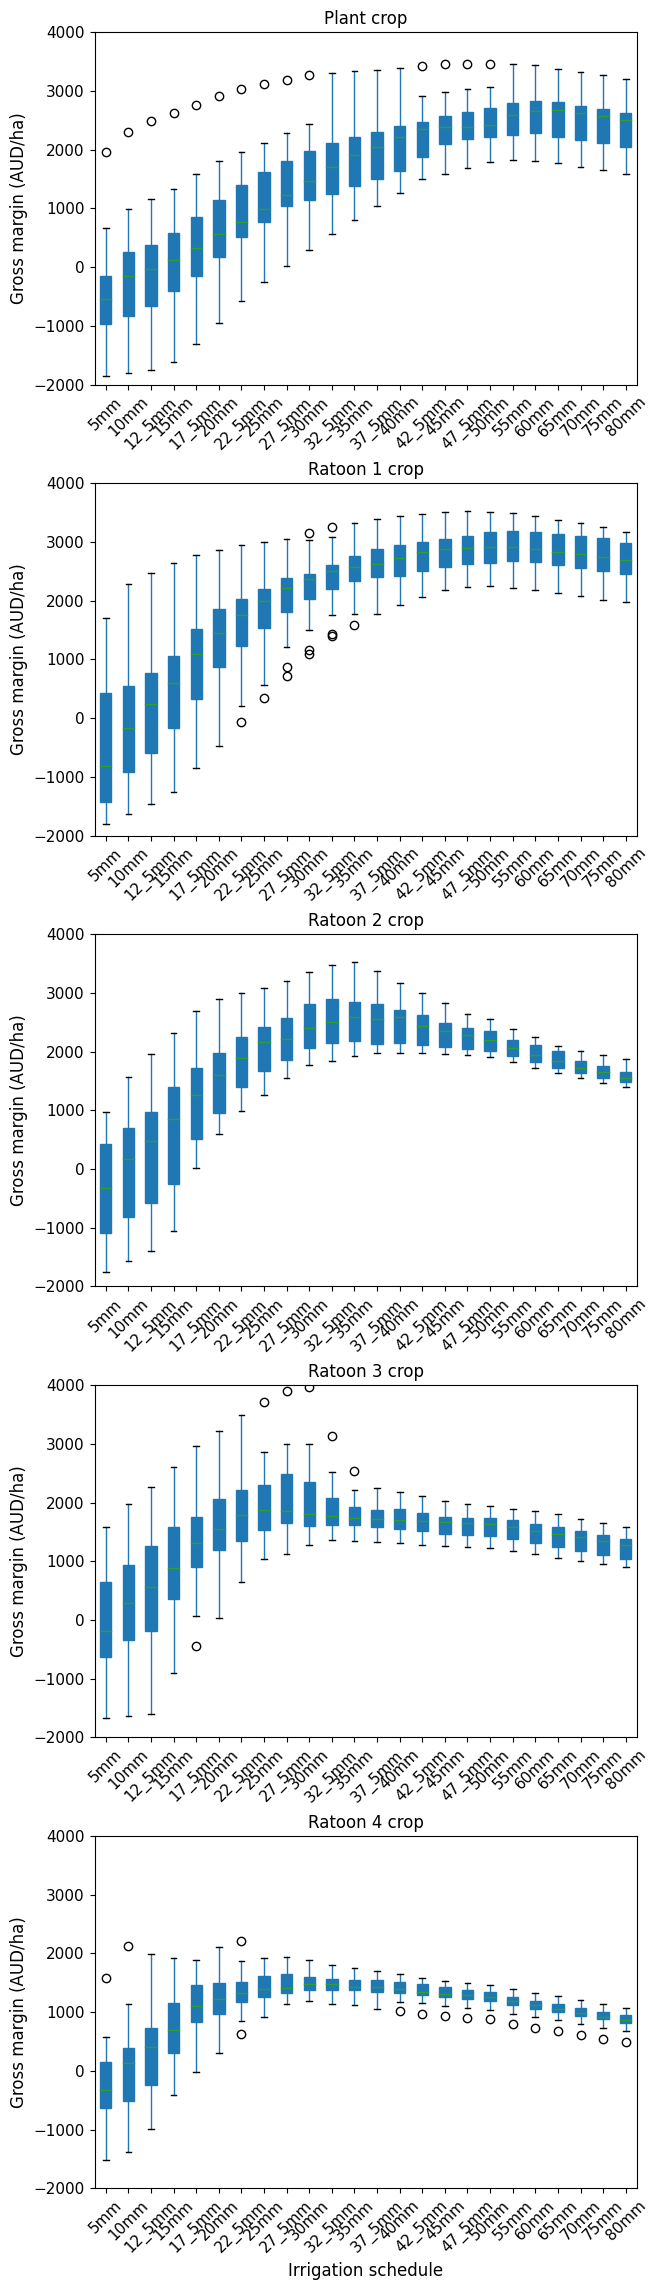

In [25]:
# Boxplots of gross margins according to irrigation schedules
fig, ax = plt.subplots(5,1)
fig.set_size_inches(7, 28)
# Plant crop
GMP.boxplot(ax = ax[0], rot=45, fontsize = 11, patch_artist = True, grid = False) 
#dfFCPs.boxplot(ax = ax, rot=45, fontsize = 13, grid = False) 
ax[0].set_title('Plant crop', fontsize=12)
ax[0].set_ylabel('Gross margin (AUD/ha)', fontsize=12)
ax[0].set_ylim(-2000,4000)
# Ratoon 1
GMR1.boxplot(ax = ax[1], rot=45, fontsize = 11, patch_artist = True, grid = False) 
ax[1].set_title('Ratoon 1 crop', fontsize=12)
ax[1].set_ylabel('Gross margin (AUD/ha)', fontsize=12)
ax[1].set_ylim(-2000,4000)
# Ratoon 2
GMR2.boxplot(ax = ax[2], rot=45, fontsize = 11, patch_artist = True, grid = False) 
ax[2].set_title('Ratoon 2 crop', fontsize=12)
ax[2].set_ylabel('Gross margin (AUD/ha)', fontsize=12)
ax[2].set_ylim(-2000,4000)
# Ratoon 3
GMR3.boxplot(ax = ax[3], rot=45, fontsize = 11, patch_artist = True, grid = False) 
ax[3].set_title('Ratoon 3 crop', fontsize=12)
ax[3].set_ylabel('Gross margin (AUD/ha)', fontsize=12)
ax[3].set_ylim(-2000,4000)
# Ratoon 4
GMR4.boxplot(ax = ax[4], rot=45, fontsize = 11, patch_artist = True, grid = False) 
ax[4].set_title('Ratoon 4 crop', fontsize=12)
ax[4].set_xlabel('Irrigation schedule', fontsize=12)
ax[4].set_ylabel('Gross margin (AUD/ha)', fontsize=12)
ax[4].set_ylim(-2000,4000)
fig.subplots_adjust(hspace=0.28)

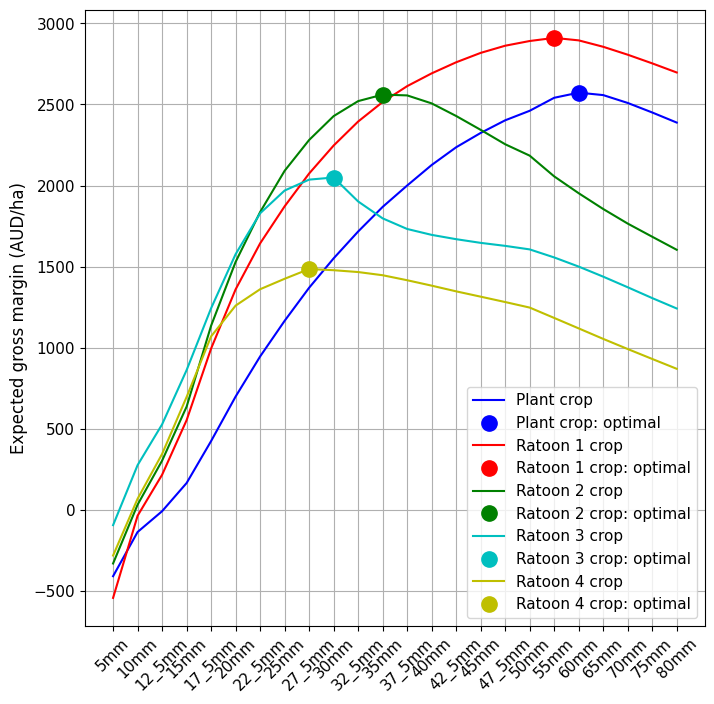

In [28]:
# Expected gross margin analysis
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8, 8)
# Plant crop
ax.plot(GMP.mean(), c = 'b', linewidth=1.5)
ax.plot(GMP.mean().idxmax(), GMP.mean().max(), 'o', c = 'b', markersize=11)     # Marking the optimal schedule 
# Ratoon 1
ax.plot(GMR1.mean(), c = 'r', linewidth=1.5)
ax.plot(GMR1.mean().idxmax(), GMR1.mean().max(), 'o', c = 'r', markersize=11)     # Marking the optimal schedule 
# Ratoon 2
ax.plot(GMR2.mean(), c = 'g', linewidth=1.5)
ax.plot(GMR2.mean().idxmax(), GMR2.mean().max(), 'o', c = 'g', markersize=11)     # Marking the optimal schedule 
# Ratoon 3
ax.plot(GMR3.mean(), c = 'c', linewidth=1.5)
ax.plot(GMR3.mean().idxmax(), GMR3.mean().max(), 'o', c = 'c', markersize=11)     # Marking the optimal schedule 
# Ratoon 4
ax.plot(GMR4.mean(), c = 'y', linewidth=1.5)
ax.plot(GMR4.mean().idxmax(), GMR4.mean().max(), 'o', c = 'y', markersize=11)     # Marking the optimal schedule 
#
ax.legend(['Plant crop', 'Plant crop: optimal',
           'Ratoon 1 crop', 'Ratoon 1 crop: optimal', 
           'Ratoon 2 crop', 'Ratoon 2 crop: optimal',
           'Ratoon 3 crop', 'Ratoon 3 crop: optimal',
           'Ratoon 4 crop', 'Ratoon 4 crop: optimal'], fontsize=11)
ax.set_ylabel('Expected gross margin (AUD/ha)', fontsize=12)
ax.tick_params(axis = 'x', labelrotation = 45, labelsize = 11)
ax.tick_params(axis = 'y', labelsize = 11)
ax.grid(True)